In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from background_models import bg_dampe
from constants import dampe_excess_bin_low, dampe_excess_bin_high, dampe_bins
from constants import rho_earth, plot_obs, t_diff, t_loss, fermi_psf
from constants import speed_of_light, kpc_to_cm, dampe_excess_iflux
from finite_clump_vectorized import dphi_de_e, rho_s_dampe, dphi_de_g
from finite_clump_vectorized import line_width_constraint, mass
from finite_clump_vectorized import rho as density_profile

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

## Profile comparison

In [11]:
gamma_exp = 0.74
gamma_nfw = 1.0
dist = 5e-2
r_s = np.logspace(-2, 2, 3)

In [12]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")
rho_s_nfw = rho_s_dampe(dist, r_s, gamma_nfw, "nfw")

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


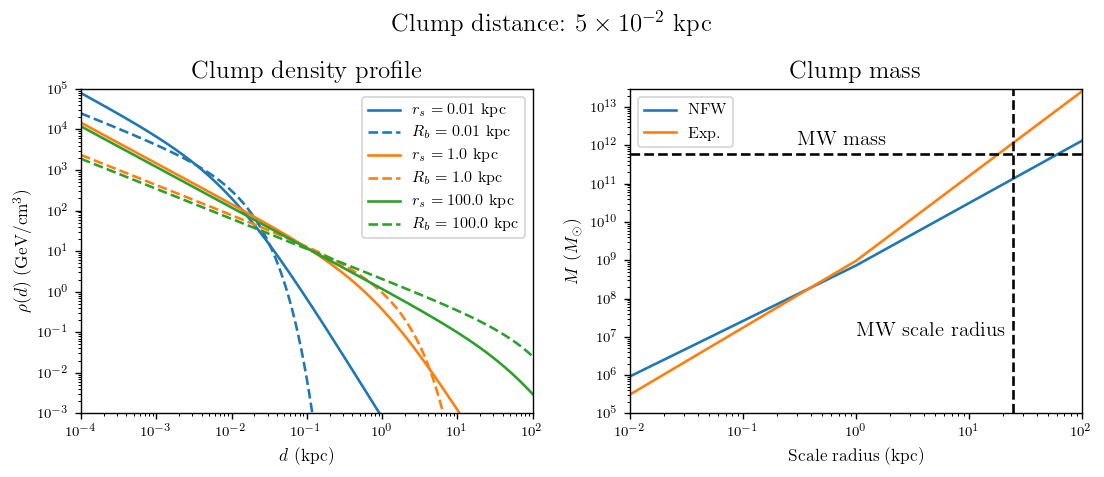

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

ax = axs[0]
rs = np.logspace(-4, 2, 200)
for r, rho_nfw, rho_exp, c in zip(r_s, rho_s_nfw, rho_s_exp, colors):
    ax.plot(rs, density_profile(rs, r, rho_nfw, gamma_nfw, "nfw"),
            color=c, label=r"$r_s = {}$ kpc".format(r))
    ax.plot(rs, density_profile(rs, r, rho_exp, gamma_exp, "exp"),
            '--', color=c, label="$R_b = {}$ kpc".format(r))

# ax.axvline(dist, color='k', linestyle='--', alpha=0.3)
# ax.axvline(1. * np.pi/180 * dist, color='k', linestyle='--')

ax.legend()
ax.set_xlim(rs[[0, -1]])
ax.set_ylim([1e-3, 1e5])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$d$ (kpc)")
ax.set_ylabel(r"$\rho(d)$ (GeV/cm$^3$)")
ax.set_title("Clump density profile")

ax = axs[1]
ax.plot(r_s, mass(r_s, rho_s_nfw, gamma_nfw, "nfw"), label="NFW")
ax.plot(r_s, mass(r_s, rho_s_exp, gamma_exp, "exp"), label="Exp.")
# Milky Way mass
ax.axhline(6e11, color='k', linestyle='--')
ax.text(3e-1, 1e12, "MW mass")
# MW scale radius
ax.axvline(24.42, color='k', linestyle='--')
ax.text(1e0, 1e7, "MW scale radius")

ax.legend()
ax.set_xlim(r_s[[0, -1]])
ax.set_ylim(1e5, 3e13)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Scale radius (kpc)")
ax.set_ylabel(r"$M$ ($M_\odot$)")
ax.set_title("Clump mass")

fig.suptitle(r"Clump distance: $5\times10^{-2}$ kpc")
fig.tight_layout(rect=[0, 0.03, 1, 0.93])

## Making sure stationarity assumption is valid

This shows the clump doesn't travel far relative to its scale radius in a propagation time. The black line is the distance traveled during one propagation time as a function of clump distance. Scale radii in the orange region are smaller than we consider. Clump distances in the blue region are ruled out by line width.

Text(0,0.5,'$r_{\\mathrm{clump}}$ (kpc)')

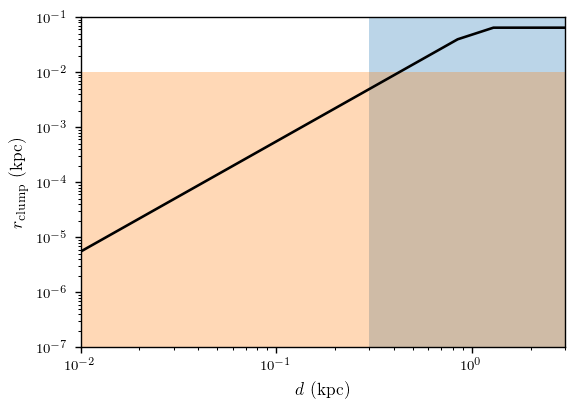

In [17]:
dist = np.logspace(-3, np.log10(3), 20)
r_s = np.logspace(-2, 2, 20)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

t_prop = np.min([t_diff(dampe_excess_bin_high, dist_mg),
                 t_loss(dampe_excess_bin_high) * np.ones_like(dist_mg)],
                axis=0)


# Distance traveled by clump during one propagation time
plt.loglog(dist, 1e-3*speed_of_light/kpc_to_cm*t_prop[-1, :], 'k')

# Shade distances ruled out by line width
plt.fill_betweenx([1e-7, 1e-1], 3e-1, 3e0, alpha=0.3)
# Shade scale radii not considered in our work
plt.fill_between([1e-2, 3e0], 1e-7, 1e-2, alpha=0.3)
plt.xlim(1e-2, 3e0)
plt.ylim(1e-7, 1e-1)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_{\mathrm{clump}}$ (kpc)")

## Propagation timescales

### Ratio

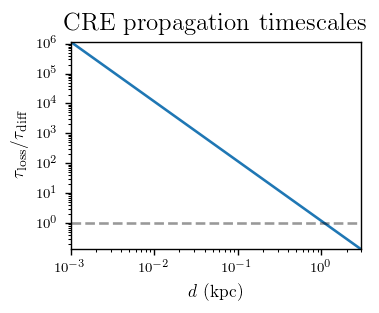

In [30]:
d = np.logspace(-3, np.log10(3e0), 200)

plt.figure(figsize=(3, 2.2))
plt.loglog(d, t_loss(dampe_excess_bin_high) / t_diff(dampe_excess_bin_high, d))
plt.axhline(1, linestyle='--', color='k', alpha=0.4)

plt.autoscale(tight=True)
plt.title("CRE propagation timescales")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\tau_{\rm loss}/\tau_{\rm diff}$")

plt.savefig("figures/propagation_timescale_ratio.pdf")

### Values

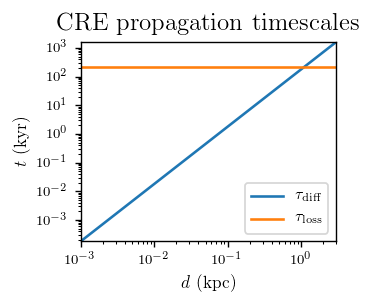

In [38]:
d = np.logspace(-3, np.log10(3e0), 200)
s_to_yr = 1./(365e3 * 24*60*60)

plt.figure(figsize=(3, 2.6))
plt.loglog(d, s_to_yr*t_diff(dampe_excess_bin_high, d), label=r"$\tau_{\rm diff}$")
plt.loglog(d, s_to_yr*np.ones_like(d)*t_loss(dampe_excess_bin_high),
           label=r"$\tau_{\rm loss}$")

plt.autoscale(tight=True)
plt.title("CRE propagation timescales")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$t$ (kyr)")
plt.legend()

plt.tight_layout()
plt.savefig("figures/propagation_timescales.pdf")

## $e^\pm$ spectra and density profiles

Compute clump normalizations and spectra

In [28]:
gamma_exp = 0.52
dist = 5e-2
r_s = np.logspace(-1, 1, 3)

In [29]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

In [30]:
e_epm = np.linspace(500, 2000, 200)

dphi_de_e_exp = []
for r, rho in zip(r_s, rho_s_exp):
    dphi_de_e_exp.append(
        dphi_de_e(e_epm, dist, r, rho, gamma_exp, "exp"))
dphi_de_e_exp = np.array(dphi_de_e_exp)

In [31]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

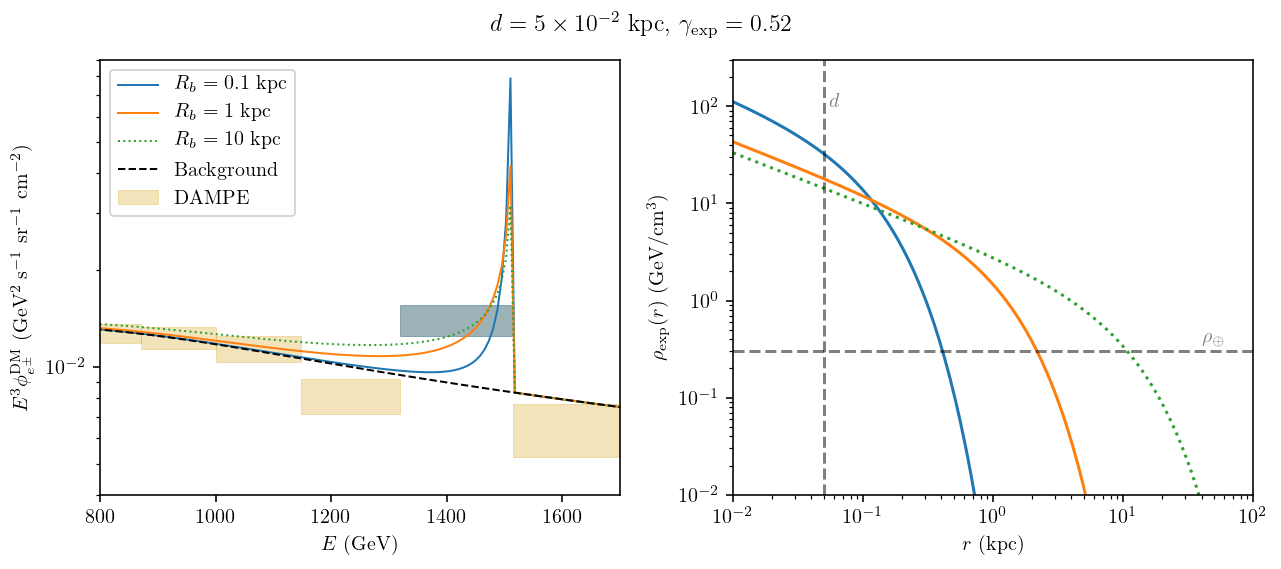

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# e+/e- fluxes
ax = axs[0]
# DAMPE observations
power = 3
plot_obs(power, ax, True)
# DM
for dphi_de, r, rho, lw_ex in zip(dphi_de_e_exp, r_s, rho_s_exp, lw_excess):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"

    if int(r) == r:
        label = r"$R_b = {}$ kpc".format(int(r))
    else:
        label = r"$R_b = {}$ kpc".format(r)
    
    # Factor of two since we want the e+- spectrum
    ax.plot(e_epm, e_epm**power * (2*dphi_de + bg_dampe(e_epm)),
            linestyle=linestyle, linewidth=1, label=label)
    
# Background only
ax.plot(e_epm, e_epm**3 * bg_dampe(e_epm), "--k",
        linewidth=1, label="Background")
# Formatting
ax.set_yscale('log')
ax.set_xlim(8e2, 1.7e3)
# ax.set_ylim(1e-12, 1e-10)  # power=0
# ax.set_ylim(2e-6, 4e-5)  # power=2
ax.set_ylim(4e-3, 9e-2)  # power=3
ax.legend()
ax.set_xlabel(r"$E$ (GeV)")
ax.set_ylabel(r"$E^3 \phi_{e^\pm}^{\rm DM}$ (GeV$^2$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

# Halo profiles
ax = axs[1]
rs = np.logspace(-2, 2, 200)
for r, rho, lw_ex in zip(r_s, rho_s_exp, lw_excess):
    if lw_ex > 3.:
        linestyle = ":"
    else:
        linestyle = "-"
    ax.loglog(rs, density_profile(rs, r, rho, gamma_exp, "exp"),
              linestyle=linestyle)
    
    rho_cl = density_profile(dist, r, rho, gamma_exp, "exp")

ax.axvline(dist, color="k", linestyle="--", alpha=0.5)
ax.text(5.5e-2, 1e2, r"$d$", alpha=0.5)
ax.axhline(rho_earth, color="k", linestyle="--", alpha=0.5)
ax.text(4e1, 3.5e-1, r"$\rho_\oplus$", alpha=0.5)
ax.set_xlim(rs[[0, -1]])
ax.set_ylim(1e-2, 3e2)
ax.set_xlabel(r"$r$ (kpc)")
ax.set_ylabel(r"$\rho_{\rm exp}(r)$ (GeV/cm$^3$)")

fig.suptitle(r"$d = 5\times 10^{-2}$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

fig.savefig("figures/epm_spectra_clump_profiles_exp.pdf")

## $\gamma$-ray spectra

Fermi broadband flux sensitivity: max flux of a power law source at the detection threshold for any power law. From [here](http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm).

### EGB, GC backgrounds

Flux from DM annihilating in the GC

In [3]:
rho_s_mw = 0.184
r_s_mw = 24.42
gamma_mw = 1.

dphi_de_g(1.5e3, 8.5, r_s_mw, rho_s_mw, gamma_mw, "nfw", th_max=fermi_psf)

array(3.86814929e-18)

### NFW

In [34]:
from constants import fermi_pt_src_sens

[Fermi EGB](https://arxiv.org/pdf/1410.3696.pdf) (Table 6, model A)

In [88]:
I100 = 1.48e-7 * 1e3 # GeV^-1 cm^-2 s^-1 sr^-1
gamma_fermi = 2.31
e_cut = 362.  # GeV

def dphi_de_fermi(e):
    return I100 * (e / 0.1)**(-gamma_fermi) * np.exp(-e / e_cut)

In [125]:
gamma_nfw = 1.
dist = 1e-2
r_s = np.logspace(-3, 2, 6)

In [126]:
rho_s_nfw = rho_s_dampe(dist, r_s, gamma_nfw, "nfw")

In [127]:
# Spectrum
e_g = np.logspace(1, np.log10(2e3), 300)

dphi_de_g_nfw = []
for r, rho in zip(r_s, rho_s_nfw):
    dphi_de_g_nfw.append(
        dphi_de_g(e_g, dist, r, rho, gamma_nfw, "nfw", fermi_psf))
dphi_de_g_nfw = np.array(dphi_de_g_nfw)

In [128]:
# Flux at E_* = 230 GeV
e_g_ref = 230.
th = np.logspace(np.log10(fermi_psf), np.log10(np.pi), 200)

dphi_de_g_th = []
for r, rho in zip(r_s, rho_s_nfw):
    temp = []
    for t in th:
        temp.append(dphi_de_g(e_g_ref, dist, r, rho, gamma_nfw, "nfw", t))
    dphi_de_g_th.append(temp)
dphi_de_g_th = np.array(dphi_de_g_th)

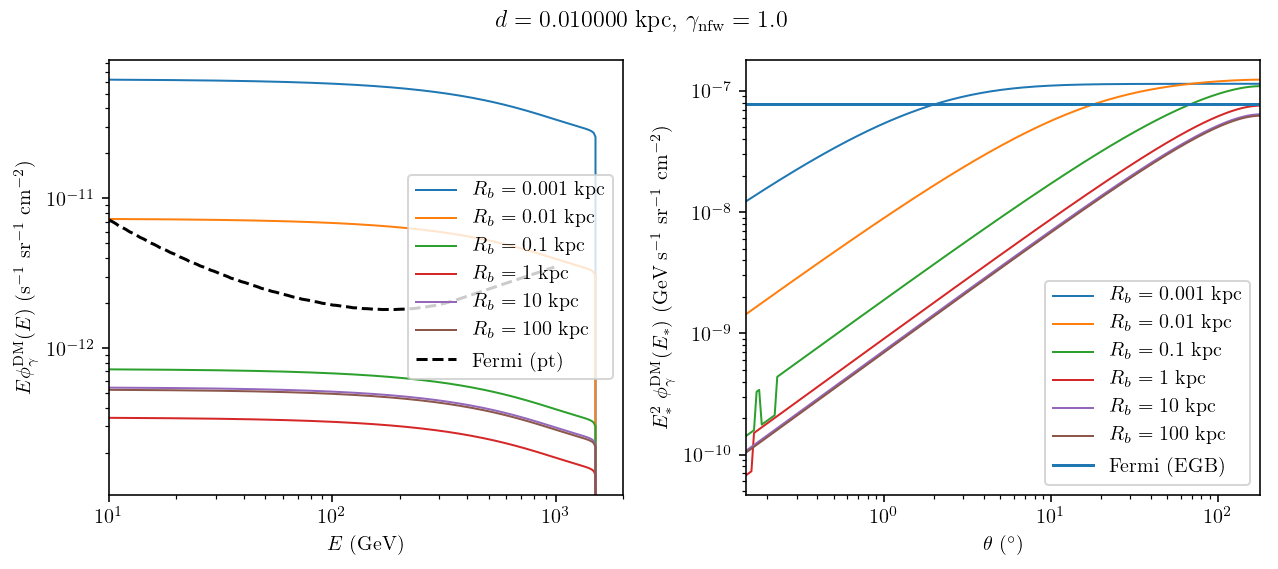

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Photon fluxes
ax = axs[0]
# DM
for dphi_de, r, rho in zip(dphi_de_g_nfw, r_s, rho_s_nfw):
    linestyle = "-"
    
    if int(r) == r:
        label = r"$R_b = {}$ kpc".format(int(r))
    else:
        label = r"$R_b = {}$ kpc".format(r)

    ax.plot(e_g, e_g * dphi_de, linestyle=linestyle, linewidth=1,
            label=label)

# Fermi point source sensitivity. Note this is above the plot range.
ax.loglog(e_g, e_g * fermi_pt_src_sens(e_g), '--k', label="Fermi (pt)")

# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(e_g[[0, -1]])
# ax.set_ylim(1e-16, 3.5e-12)
ax.legend()
ax.set_xlabel(r"$E$ (GeV)")
ax.set_ylabel(r"$E \phi_\gamma^{\rm DM}(E)$ (s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

# Angular dependence
ax = axs[1]
power = 2
for dphi_de_th, r, rho in zip(dphi_de_g_th, r_s, rho_s_nfw):
    linestyle = "-"
    
    if int(r) == r:
        label = r"$R_b = {}$ kpc".format(int(r))
    else:
        label = r"$R_b = {}$ kpc".format(r)

    ax.plot(th * 180/np.pi, e_g_ref**power * dphi_de_th,
            linestyle=linestyle, linewidth=1, label=label)

ax.axhline(1.1 * e_g_ref**power * dphi_de_fermi(e_g_ref), label="Fermi (EGB)")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(th[[0, -1]] * 180/np.pi)
# ax.set_ylim(1e-12, 1e-11)
ax.legend()
ax.set_xlabel(r"$\theta$ ($^\circ$)")
ax.set_ylabel(r"$E_*^2 ~ \phi_\gamma^{\rm DM}(E_*)$ (GeV s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")


# fig.suptitle(r"$d = 5\times 10^{-2}$ kpc, $\gamma_{\rm nfw} = %.2f$" % gamma_nfw)
fig.suptitle(r"$d = {%f}$ kpc, $\gamma_{\rm nfw} = %.1f$" % (dist, gamma_nfw))
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# fig.savefig("figures/ep_spectra_clump_profiles_nfw_0.52.pdf")

In [220]:
dist = 1e-2
r_s = np.logspace(-3, -1, 3)
rho_s_nfw = rho_s_dampe(dist, r_s, gamma_nfw, "nfw")

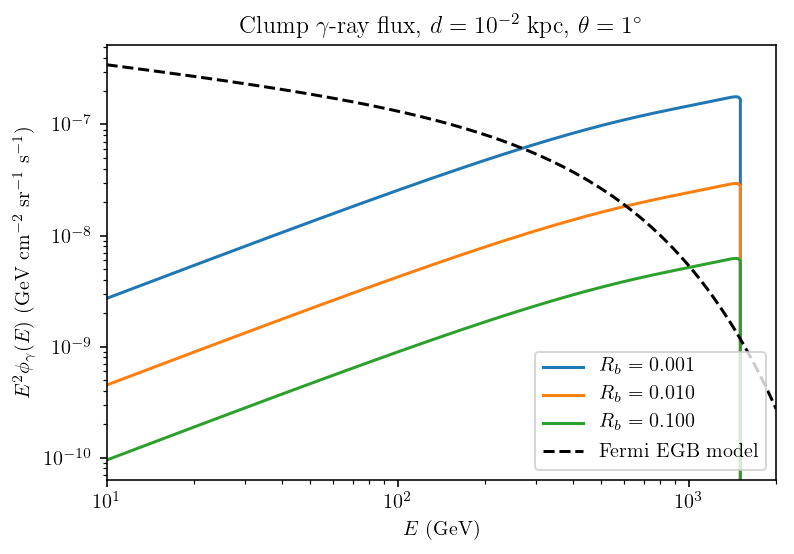

In [222]:
for r, rho in zip(r_s, rho_s_nfw):
    plt.loglog(e_g, e_g**2 * dphi_de_g(e_g, dist, r, rho, gamma_nfw, "nfw", 1. * np.pi/180),
               label=r"$R_b = %.3f$" % r)
plt.loglog(e_g, e_g**2 * dphi_de_fermi(e_g), '--k', label="Fermi EGB model")

plt.xlim(1e1, 2e3)
plt.xlabel(r"$E$ (GeV)")
plt.ylabel(r"$E^2 \phi_\gamma(E)$ (GeV cm$^{-2}$ sr$^{-1}$ s$^{-1}$)")
plt.title(r"Clump $\gamma$-ray flux, $d = 10^{-2}$ kpc, $\theta = 1^\circ$")
plt.legend()

In [204]:
r_s = np.array(1e2)

peak_flux = []
for d in np.logspace(-3, 1):
    rho = rho_s_dampe(d, r_s, gamma_nfw, "nfw")
    peak_flux.append(dphi_de_g(0.99*dampe_excess_bin_high, d,
                               r, rho, gamma_nfw, "nfw", 0.5 * np.pi/180))
peak_flux = np.array(peak_flux)

Text(0.5,1,'$r_s = 100.000000$ kpc')

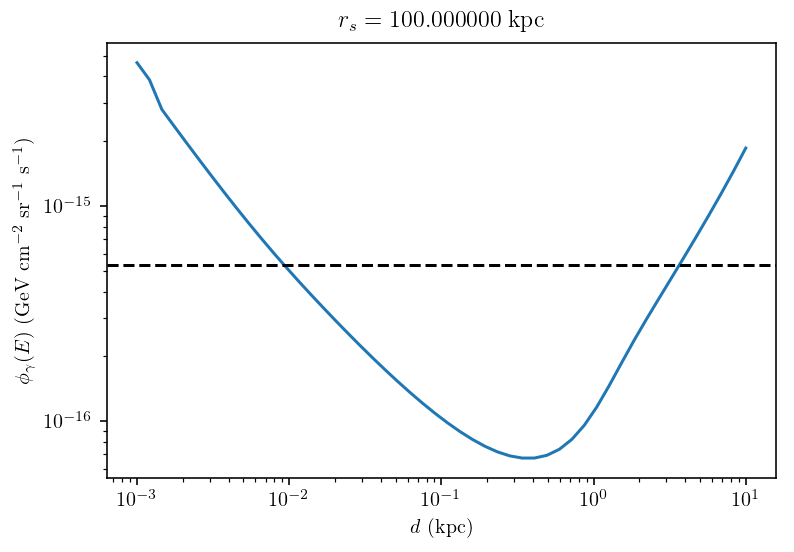

In [205]:
plt.loglog(np.logspace(-3, 1), peak_flux)
plt.axhline(dphi_de_fermi(0.99*dampe_excess_bin_high), color='k', linestyle='--')

plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\phi_\gamma(E)$ (GeV cm$^{-2}$ sr$^{-1}$ s$^{-1}$)")
plt.title(r"$r_s = %f$ kpc" % r_s)

In [190]:
from scipy.optimize import minimize_scalar

In [ ]:
r_s = np.logspace(-2, 2, 50)

def fn(d, r):

for r in r_s:

### Exp

In [34]:
from constants import fermi_pt_src_sens

In [63]:
gamma_exp = 0.52
dist = 1e-3
r_s = np.logspace(-1, 1, 3)

In [64]:
rho_s_exp = rho_s_dampe(dist, r_s, gamma_exp, "exp")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [65]:
# Spectrum
e_g = np.logspace(1, np.log10(2e3), 300)

dphi_de_g_exp = []
for r, rho in zip(r_s, rho_s_exp):
    dphi_de_g_exp.append(
        dphi_de_g(e_g, dist, r, rho, gamma_exp, "exp", fermi_psf))
dphi_de_g_exp = np.array(dphi_de_g_exp)

In [66]:
# Flux at E_* = 230 GeV
e_g_ref = 230.
th = np.linspace(fermi_psf, 100*fermi_psf)

dphi_de_g_th = []
for r, rho in zip(r_s, rho_s_exp):
    temp = []
    for t in th:
        temp.append(dphi_de_g(e_g_ref, dist, r, rho, gamma_exp, "exp", t))
    dphi_de_g_th.append(temp)
dphi_de_g_th = np.array(dphi_de_g_th)

In [39]:
# Determine whether the clump is excluded by line width
lw_excess = []

for r, rho in zip(r_s, rho_s_exp):
    lw_excess.append(line_width_constraint(dist, r, rho, gamma_exp, "exp"))
    
lw_excess = np.array(lw_excess)

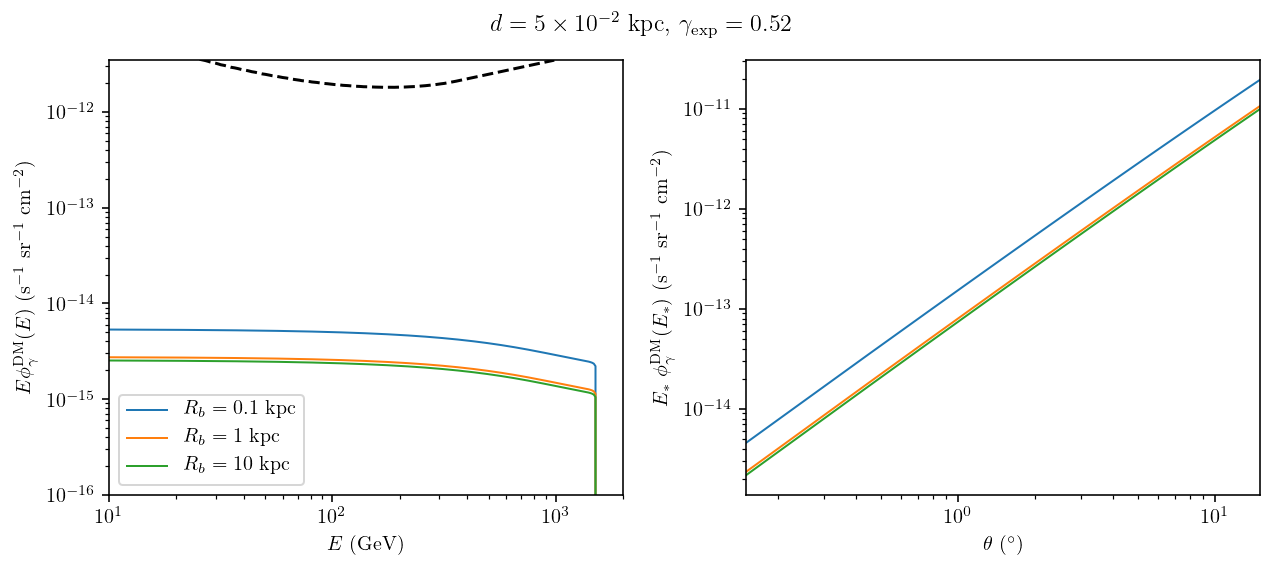

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Photon fluxes
ax = axs[0]
# DAMPE observations
power = 1
# DM
for dphi_de, r, rho, lw_ex in zip(dphi_de_g_exp, r_s, rho_s_exp, lw_excess):
#     if lw_ex > 3.:
#         linestyle = ":"
#     else:
#         linestyle = "-"
    linestyle = "-"
    
    if int(r) == r:
        label = r"$R_b = {}$ kpc".format(int(r))
    else:
        label = r"$R_b = {}$ kpc".format(r)

    ax.plot(e_g, e_g**power * dphi_de, linestyle=linestyle, linewidth=1,
            label=label)

# Fermi point source sensitivity. Note this is above the plot range.
ax.loglog(e_g, e_g**power * fermi_pt_src_sens(e_g), '--k')

# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(e_g[[0, -1]])
ax.set_ylim(1e-16, 3.5e-12)
ax.legend()
ax.set_xlabel(r"$E$ (GeV)")
ax.set_ylabel(r"$E \phi_\gamma^{\rm DM}(E)$ (s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")

# Angular dependence
ax = axs[1]
for dphi_de_th, r, rho, lw_ex in zip(dphi_de_g_th, r_s, rho_s_exp, lw_excess):
#     if lw_ex > 3.:
#         linestyle = ":"
#     else:
#         linestyle = "-"
    linestyle = "-"
    
    if int(r) == r:
        label = r"$R_b = {}$ kpc".format(int(r))
    else:
        label = r"$R_b = {}$ kpc".format(r)

    ax.plot(th * 180/np.pi, e_g_ref**power * dphi_de_th, linestyle=linestyle, linewidth=1,
            label=label)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(th[[0, -1]] * 180/np.pi)
# ax.set_ylim(1e-12, 1e-11)
ax.set_xlabel(r"$\theta$ ($^\circ$)")
ax.set_ylabel(r"$E_* ~ \phi_\gamma^{\rm DM}(E_*)$ (s$^{-1}$ sr$^{-1}$ cm$^{-2}$)")


fig.suptitle(r"$d = 5\times 10^{-2}$ kpc, $\gamma_{\rm exp} = %.2f$" % gamma_exp)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# fig.savefig("figures/ep_spectra_clump_profiles_exp_0.52.pdf")

# Scratch

In [162]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

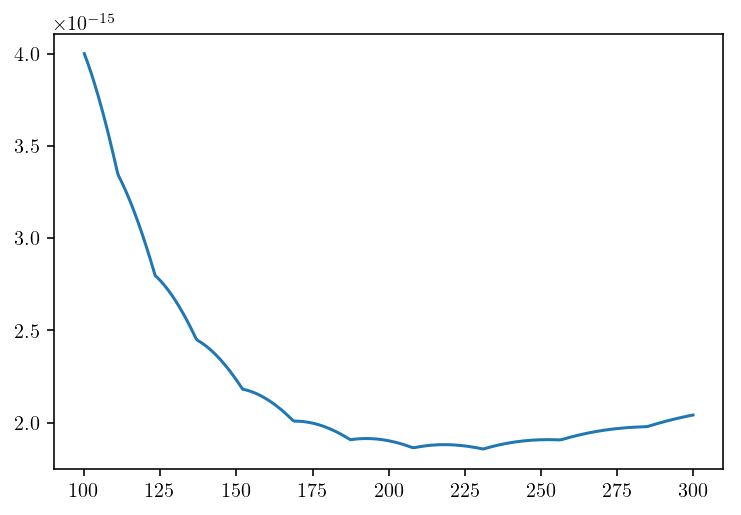

In [173]:
plt.plot(e_g, fermi_sensitivity_interp(e_g) - dphi_de)

In [169]:
dm_g_interp = interp1d(e_g, dphi_de)
fermi_sensitivity_interp = interp1d(e_g_f, dphi_de_g_f, bounds_error=False)

In [168]:
minimize_scalar(lambda e: fermi_sensitivity_interp(e) - dm_g_interp(e), bracket=(100, 200, 299))

     fun: 1.8561561777316065e-15
    nfev: 33
     nit: 29
 success: True
       x: 231.00999984255506

(1e-15, 3e-15)

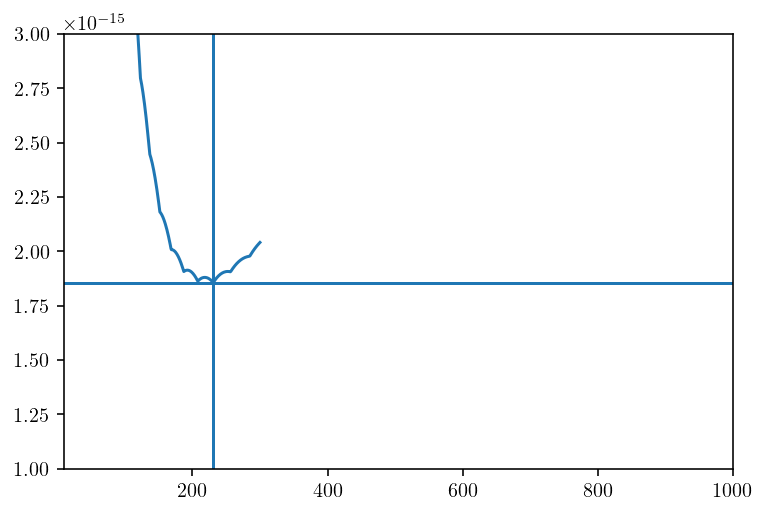

In [174]:
plt.plot(e_g, fermi_sensitivity_interp(e_g) - dphi_de)
plt.axvline(230)
plt.axhline(1.8558198565093894e-15)
# plt.plot(e_g_f, dphi_de_g_f, '--k')
plt.xlim(1e1, 1e3)
plt.ylim(1e-15, 3e-15)

How to set a point source constraint with Fermi:
1. Find $E_*$, the energy where the gamma-ray spectrum first touches Fermi's sensitivity curve. Since the DM mass is held fixed at ~1.5 TeV and the spectrum is always the AP one, this is fixed in our analysis. Turns out $E_* \approx 230$ GeV.
2. Get $\phi_\gamma^{\rm DM}(E_*)$ for the clump with $\rho_s = 1$ by integrating over the angular region for a point source.
3. Since $\phi_\gamma^{\rm DM}(E_*) \propto \rho_s^2$, under the assumption the clump was not detected the Fermi constraint on $\rho_s$ is

$$\rho_s \leq \sqrt{\phi_\gamma^{\rm Fermi} / \phi_\gamma^{\rm DM}}.$$

In [113]:
1e-2/2.5e-3

4.0